In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.6.0'

## Model

In [3]:
# util
def x_to_input(x):
    return keras.Input(shape=x.shape[1:]) # remove batch size

In [4]:
class ResidualBlock:
    def Basic(x, filters, strides, residual):
        assert 0 < filters
        assert 0 < strides

        inputs = x_to_input(x) # remove batch size
        identity = inputs

        # 1) 3x3 conv
        x = keras.layers.Conv2D(filters,
                                kernel_size=3,
                                padding="same",
                                strides=strides)(inputs)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

        # 2) 3x3 conv
        x = keras.layers.Conv2D(filters,
                                kernel_size=3,
                                padding="same",
                                strides=1)(x)
        x = keras.layers.BatchNormalization()(x)

        if residual:
            # input과 conv output를 더하기 위해 input의 차원을 맞춘다
            if (x.shape[1] != identity.shape[1] # kernel size가 다른 경우
                or x.shape[-1] != identity.shape[-1]): # channel size가 다른 경우

                identity = keras.layers.Conv2D(filters,
                                            kernel_size=1,
                                            padding="same",
                                            strides=strides)(identity)

            x = keras.layers.Add()([x, identity])

        outputs = keras.layers.ReLU()(x)
        return keras.Model(inputs, outputs)
    
    def Bottleneck(x, filters, strides, residual):
        assert 0 < filters and filters % 4 == 0
        assert 0 < strides

        inputs = x_to_input(x)
        identity = inputs

        # 1) 1x1 conv
        x = keras.layers.Conv2D(filters//4,
                                kernel_size=1,
                                padding="same",
                                strides=1)(inputs)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

        # 2) 3x3 conv
        x = keras.layers.Conv2D(filters//4,
                                kernel_size=3,
                                padding="same",
                                strides=strides)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

        # 3) 1x1 conv
        x = keras.layers.Conv2D(filters,
                                kernel_size=1,
                                padding="same",
                                strides=1)(x)
        x = keras.layers.BatchNormalization()(x)

        if residual:
            # input과 conv output를 더하기 위해 input의 차원을 맞춘다
            if (x.shape[1] != identity.shape[1] # kernel size가 다른 경우
                or x.shape[-1] != identity.shape[-1]): # channel size가 다른 경우

                identity = keras.layers.Conv2D(filters,
                                            kernel_size=1,
                                            padding="same",
                                            strides=strides)(identity) 

            x = keras.layers.Add()([x, identity])

        outputs = keras.layers.ReLU()(x)
        return keras.Model(inputs, outputs)
    
    def layer(x, layer_name, block, blocks, filters, strides, residual):
        assert 0 < blocks
    
        inputs = x_to_input(x)
        
        x = block(x=inputs, filters=filters, strides=strides, residual=residual)(inputs)

        for _ in range(1, blocks):
            x = block(x=x, filters=filters, strides=1, residual=residual)(x)

        return keras.Model(inputs, x, name=layer_name)

In [5]:
RESNET34_CONFIG = [
    (3, 64, 1),
    (4, 128, 2),
    (6, 256, 2),
    (3, 512, 2),
]
RESNET50_CONFIG = [
    (3, 256, 1),
    (4, 512, 2),
    (6, 1024, 2),
    (3, 2048, 2),
]

def build_resnet(input_shape, num_classes, is_34=False, is_50=False):
    assert is_34 or is_50
    
    if is_34:
         return resnet(
             input_shape=input_shape,
             num_classes=num_classes,
             config=RESNET34_CONFIG,
             block=ResidualBlock.Basic,
             model_name="ResNet34",
             residual=True,
        )
    
    if is_50:
         return resnet(
             input_shape=input_shape,
             num_classes=num_classes,
             config=RESNET50_CONFIG,
             block=ResidualBlock.Bottleneck,
             model_name="ResNet50",
             residual=True,
        )
        
def build_plainnet(input_shape, num_classes, is_34=False, is_50=False):
    assert is_34 or is_50
    
    if is_34:
         return resnet(
             input_shape=input_shape,
             num_classes=num_classes,
             config=RESNET34_CONFIG,
             block=ResidualBlock.Basic,
             model_name="PlainNet34",
             residual=False,
        )
    
    if is_50:
         return resnet(
             input_shape=input_shape,
             num_classes=num_classes,
             config=RESNET50_CONFIG,
             block=ResidualBlock.Bottleneck,
             model_name="PlainNet50",
             residual=False,
        )
    
def resnet(input_shape, num_classes, config, block, model_name, residual=True):
    inputs = keras.Input(input_shape, name="input")
    curr_filters = 64
    
    # conv1
    x = keras.layers.Conv2D(64,
                            kernel_size=7,
                            padding="same",
                            strides=2,
                            name="conv1")(inputs)

    # conv2_x
    x = keras.layers.MaxPool2D(pool_size=3, 
                               padding="same",
                               strides=2,
                               name="conv2_x_maxpool")(x)
    # residual blocks at conv2_x ~ conv5_x
    for i, (blocks, filters, strides) in enumerate(config):
        layer_num = i + 2
        x = ResidualBlock.layer(x, layer_name=f"conv{layer_num}_x", block=block,
                                blocks=blocks, filters=filters, strides=strides,
                                residual=residual)(x)
    
    # classifier
    x = keras.layers.GlobalAveragePooling2D(name="GAP")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)
    return keras.Model(inputs, outputs, name=model_name)

In [6]:
# example
print("=============ResNet34=============")
resnet34 = build_resnet(input_shape=(224,224,3), num_classes=1_000, is_34=True)
resnet34.summary()

print("\n\n=============ResNet50=============")
resnet50 = build_resnet(input_shape=(224,224,3), num_classes=1_000, is_50=True)
resnet50.summary()

=============ResNet34=============
Model: "ResNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
conv2_x_maxpool (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_x (Functional)         (None, 56, 56, 64)        223104    
_________________________________________________________________
conv3_x (Functional)         (None, 28, 28, 128)       1119360   
_________________________________________________________________
conv4_x (Functional)         (None, 14, 14, 256)       6831360   
_________________________________________________________________
conv5_x (Functional)   

In [7]:
# example
print("=============PlainNet34=============")
plainnet34 = build_plainnet(input_shape=(224,224,3), num_classes=1_000, is_34=True)
plainnet34.summary()

print("\n\n=============PlainNet50=============")
plainnet50 = build_plainnet(input_shape=(224,224,3), num_classes=1_000, is_50=True)
plainnet50.summary()

=============PlainNet34=============
Model: "PlainNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
conv2_x_maxpool (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_x (Functional)         (None, 56, 56, 64)        223104    
_________________________________________________________________
conv3_x (Functional)         (None, 28, 28, 128)       1111040   
_________________________________________________________________
conv4_x (Functional)         (None, 14, 14, 256)       6798336   
_________________________________________________________________
conv5_x (Functional

## Data

In [8]:
# https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=ko
setattr(tfds.image_classification.cats_vs_dogs, 
        "_URL",
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

dataset, ds_info = tfds.load("cats_vs_dogs", 
                              as_supervised=True,
                              shuffle_files=True,
                              with_info=True)

### label 확인

In [9]:
feature_label = ds_info.features["label"]

for name in feature_label.names:
    print(f"{name}: {feature_label.str2int(name)}")

cat: 0
dog: 1


In [10]:
def get_label_counts(ds):
    label_counter = [0, 0]

    for _, label in ds:
        label = int(label)
        label_counter[label] += 1
    
    return label_counter

# label 별 데이터 수가 어느정도 고르게 분포되어있다
label_counter = get_label_counts(dataset["train"])
print("Label 별 데이터 분포 확인")
print("0:", label_counter[0])
print("1:", label_counter[1])

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


Label 별 데이터 분포 확인
0: 11658
1: 11604


Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


### data sample

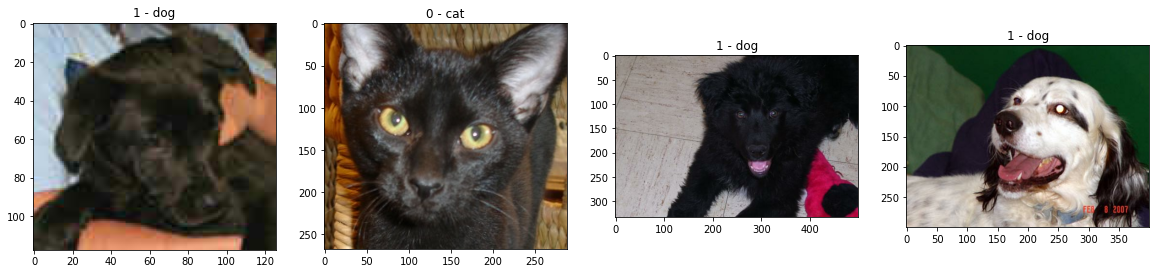

In [11]:
plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(dataset["train"].take(4)):
    plt.subplot(1,4,i+1)
    plt.imshow(image)
    label = label.numpy()
    plt.title(f"{label} - {feature_label.int2str(label)}")
    

### Data 분리

In [12]:
train_ds = dataset["train"].take(20_000)
val_ds = dataset["train"].skip(20_000)

label_counter = get_label_counts(train_ds)
print("[훈련 데이터] Label 별 데이터 분포 확인")
print("0:", label_counter[0])
print("1:", label_counter[1])

label_counter = get_label_counts(val_ds)
print("[검증 데이터] Label 별 데이터 분포 확인")
print("0:", label_counter[0])
print("1:", label_counter[1])

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


[훈련 데이터] Label 별 데이터 분포 확인
0: 10028
1: 9972


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


[검증 데이터] Label 별 데이터 분포 확인
0: 1628
1: 1634


### preprocess data

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
INPUT_SHAPE = (224,224,3)

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, INPUT_SHAPE[:2])
    image = image / 255.0
    return image, label

train_ds = (train_ds
            .map(preprocess_image, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.experimental.AUTOTUNE))

val_ds = (val_ds
          .map(preprocess_image, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.experimental.AUTOTUNE))

## Train

In [14]:
EPOCHS = 20

def train(model, epochs):
    model.compile(loss="binary_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds,
                     use_multiprocessing=True)

In [15]:
def diff_history(name1, history1, name2, history2):
    history1_dict = history1.history
    h1_loss = history1_dict['loss']
    h1_val_loss = history1_dict['val_loss']

    history2_dict = history2.history
    h2_loss = history2_dict['loss']
    h2_val_loss = history2_dict['val_loss']

    epochs1 = range(1, len(h1_loss) + 1)
    epochs2 = range(1, len(h2_loss) + 1)

    fig = plt.figure(figsize=(12, 5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs1, h1_loss, 'b-', label=f'[{name1}] train_loss')
    ax1.plot(epochs1, h1_val_loss, 'r-', label=f'[{name1}] val_loss')
    ax1.plot(epochs2, h2_loss, 'b--', label=f'[{name2}] train_loss')
    ax1.plot(epochs2, h2_val_loss, 'r--', label=f'[{name2}] val_loss')
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    h1_accuracy = history1_dict['accuracy']
    h1_val_accuracy = history1_dict['val_accuracy']

    h2_accuracy = history2_dict['accuracy']
    h2_val_accuracy = history2_dict['val_accuracy']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs1, h1_accuracy, 'b-', label=f'[{name1}] train_accuracy')
    ax2.plot(epochs1, h1_val_accuracy, 'r-', label=f'[{name1}] val_accuracy')
    ax2.plot(epochs2, h2_accuracy, 'b--', label=f'[{name2}] train_accuracy')
    ax2.plot(epochs2, h2_val_accuracy, 'r--', label=f'[{name2}] val_accuracy')
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

### 34-layer network

In [16]:
resnet34 = build_resnet(input_shape=INPUT_SHAPE, num_classes=1, is_34=True)
plainnet34 = build_plainnet(input_shape=INPUT_SHAPE, num_classes=1, is_34=True)

resnet34_history = train(resnet34, epochs=EPOCHS)
plainnet34_history = train(plainnet34, epochs=EPOCHS)

Epoch 1/20
221/625 [=========>....................] - ETA: 1:05 - loss: 0.8085 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 59s - loss: 0.7888 - accuracy: 0.4975

270/625 [===========>..................] - ETA: 57s - loss: 0.7844 - accuracy: 0.4966

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.7654 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 42s - loss: 0.7497 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 42s - loss: 0.7494 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 39s - loss: 0.7455 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.7199 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 123s 186ms/step - loss: 0.7042 - accuracy: 0.4986 - val_loss: 0.7156 - val_accuracy: 0.4997
Epoch 2/20
221/625 [=========>....................] - ETA: 1:06 - loss: 0.6121 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 59s - loss: 0.6101 - accuracy: 0.4971 

272/625 [============>.................] - ETA: 57s - loss: 0.6092 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.6037 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 42s - loss: 0.6022 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 42s - loss: 0.6021 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 40s - loss: 0.5997 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 14s - loss: 0.5875 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.5800 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.5800 - accuracy: 0.4985 - val_loss: 0.8782 - val_accuracy: 0.5003
Epoch 3/20
224/625 [=========>....................] - ETA: 1:05 - loss: 0.5277 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:00 - loss: 0.5267 - accuracy: 0.4967

271/625 [============>.................] - ETA: 57s - loss: 0.5256 - accuracy: 0.4973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 50s - loss: 0.5193 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 42s - loss: 0.5165 - accuracy: 0.5033

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 42s - loss: 0.5161 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 40s - loss: 0.5154 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 14s - loss: 0.5048 - accuracy: 0.4984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.4960 - accuracy: 0.4988 - val_loss: 0.5439 - val_accuracy: 0.4991
Epoch 4/20
223/625 [=========>....................] - ETA: 1:05 - loss: 0.4468 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:00 - loss: 0.4454 - accuracy: 0.4969

272/625 [============>.................] - ETA: 57s - loss: 0.4465 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 50s - loss: 0.4406 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 43s - loss: 0.4354 - accuracy: 0.5033

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 42s - loss: 0.4353 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 40s - loss: 0.4342 - accuracy: 0.5025

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 14s - loss: 0.4198 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 186ms/step - loss: 0.4120 - accuracy: 0.4988 - val_loss: 0.5718 - val_accuracy: 0.5000
Epoch 5/20
222/625 [=========>....................] - ETA: 1:05 - loss: 0.3579 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 1:00 - loss: 0.3564 - accuracy: 0.4974

271/625 [============>.................] - ETA: 58s - loss: 0.3574 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 51s - loss: 0.3523 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 43s - loss: 0.3539 - accuracy: 0.5034

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 42s - loss: 0.3526 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 40s - loss: 0.3527 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 14s - loss: 0.3399 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 186ms/step - loss: 0.3349 - accuracy: 0.4987 - val_loss: 0.6750 - val_accuracy: 0.5003
Epoch 6/20
222/625 [=========>....................] - ETA: 1:06 - loss: 0.2826 - accuracy: 0.4977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 1:00 - loss: 0.2804 - accuracy: 0.4977

271/625 [============>.................] - ETA: 58s - loss: 0.2802 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.2774 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 42s - loss: 0.2775 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 42s - loss: 0.2775 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 40s - loss: 0.2772 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 14s - loss: 0.2731 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.2692 - accuracy: 0.4985 - val_loss: 0.9382 - val_accuracy: 0.5018
Epoch 7/20
221/625 [=========>....................] - ETA: 1:05 - loss: 0.2490 - accuracy: 0.4967

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 59s - loss: 0.2499 - accuracy: 0.4975 

269/625 [===========>..................] - ETA: 58s - loss: 0.2492 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 50s - loss: 0.2453 - accuracy: 0.5011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 42s - loss: 0.2423 - accuracy: 0.5027

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 41s - loss: 0.2418 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 40s - loss: 0.2417 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 14s - loss: 0.2331 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.2312 - accuracy: 0.4985 - val_loss: 0.3031 - val_accuracy: 0.5000
Epoch 8/20
222/625 [=========>....................] - ETA: 1:05 - loss: 0.2012 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:00 - loss: 0.2017 - accuracy: 0.4969

272/625 [============>.................] - ETA: 57s - loss: 0.2011 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 50s - loss: 0.2049 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 42s - loss: 0.2028 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 42s - loss: 0.2026 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 40s - loss: 0.2034 - accuracy: 0.5031

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 14s - loss: 0.2005 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.2003 - accuracy: 0.4985 - val_loss: 0.7486 - val_accuracy: 0.5009
Epoch 9/20
222/625 [=========>....................] - ETA: 1:05 - loss: 0.1755 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:00 - loss: 0.1761 - accuracy: 0.4979

269/625 [===========>..................] - ETA: 58s - loss: 0.1758 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 50s - loss: 0.1765 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 42s - loss: 0.1745 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 42s - loss: 0.1738 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 40s - loss: 0.1732 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 14s - loss: 0.1686 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.1693 - accuracy: 0.4985 - val_loss: 0.3260 - val_accuracy: 0.5006
Epoch 10/20
221/625 [=========>....................] - ETA: 1:06 - loss: 0.1552 - accuracy: 0.4975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


260/625 [===========>..................] - ETA: 59s - loss: 0.1546 - accuracy: 0.4971

271/625 [============>.................] - ETA: 57s - loss: 0.1525 - accuracy: 0.4967

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


316/625 [==============>...............] - ETA: 50s - loss: 0.1553 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 42s - loss: 0.1542 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 42s - loss: 0.1533 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 40s - loss: 0.1526 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.1499 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.1484 - accuracy: 0.4986 - val_loss: 0.4440 - val_accuracy: 0.4994
Epoch 11/20
223/625 [=========>....................] - ETA: 1:05 - loss: 0.1333 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 59s - loss: 0.1335 - accuracy: 0.4972 

269/625 [===========>..................] - ETA: 58s - loss: 0.1328 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.1300 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 42s - loss: 0.1314 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 42s - loss: 0.1311 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 40s - loss: 0.1299 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.1247 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.1263 - accuracy: 0.4986 - val_loss: 0.5014 - val_accuracy: 0.5000
Epoch 12/20
223/625 [=========>....................] - ETA: 1:05 - loss: 0.1199 - accuracy: 0.4971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 59s - loss: 0.1173 - accuracy: 0.4978 

271/625 [============>.................] - ETA: 57s - loss: 0.1181 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.1161 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 42s - loss: 0.1168 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 40s - loss: 0.1167 - accuracy: 0.5031

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.1136 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.1131 - accuracy: 0.4985 - val_loss: 0.4400 - val_accuracy: 0.4991
Epoch 13/20
224/625 [=========>....................] - ETA: 1:05 - loss: 0.0987 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 59s - loss: 0.1015 - accuracy: 0.4976 

272/625 [============>.................] - ETA: 57s - loss: 0.1013 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 50s - loss: 0.1000 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 42s - loss: 0.0982 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 42s - loss: 0.0982 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 40s - loss: 0.0984 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 14s - loss: 0.0971 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.0942 - accuracy: 0.4984 - val_loss: 0.3296 - val_accuracy: 0.5006
Epoch 14/20
224/625 [=========>....................] - ETA: 1:05 - loss: 0.0733 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 1:00 - loss: 0.0732 - accuracy: 0.4975

270/625 [===========>..................] - ETA: 58s - loss: 0.0748 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.0765 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 42s - loss: 0.0761 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 42s - loss: 0.0760 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 40s - loss: 0.0759 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 14s - loss: 0.0759 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.0753 - accuracy: 0.4986 - val_loss: 0.6474 - val_accuracy: 0.5000
Epoch 15/20
221/625 [=========>....................] - ETA: 1:06 - loss: 0.0741 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 59s - loss: 0.0757 - accuracy: 0.4975 

270/625 [===========>..................] - ETA: 58s - loss: 0.0745 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.0716 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 42s - loss: 0.0681 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 42s - loss: 0.0682 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 40s - loss: 0.0670 - accuracy: 0.5030

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.0656 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 186ms/step - loss: 0.0677 - accuracy: 0.4986 - val_loss: 0.3144 - val_accuracy: 0.5009
Epoch 16/20
221/625 [=========>....................] - ETA: 1:06 - loss: 0.0670 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:00 - loss: 0.0662 - accuracy: 0.4971

272/625 [============>.................] - ETA: 57s - loss: 0.0652 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 51s - loss: 0.0632 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 43s - loss: 0.0589 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 41s - loss: 0.0587 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 40s - loss: 0.0593 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 14s - loss: 0.0562 - accuracy: 0.4983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.0575 - accuracy: 0.4985 - val_loss: 0.2587 - val_accuracy: 0.5015
Epoch 17/20
222/625 [=========>....................] - ETA: 1:06 - loss: 0.0533 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:00 - loss: 0.0532 - accuracy: 0.4978

269/625 [===========>..................] - ETA: 58s - loss: 0.0528 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 50s - loss: 0.0522 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 42s - loss: 0.0529 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 42s - loss: 0.0528 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 40s - loss: 0.0530 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 14s - loss: 0.0507 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.0494 - accuracy: 0.4984 - val_loss: 0.5204 - val_accuracy: 0.4991
Epoch 18/20
221/625 [=========>....................] - ETA: 1:06 - loss: 0.0425 - accuracy: 0.4975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 59s - loss: 0.0425 - accuracy: 0.4973 

270/625 [===========>..................] - ETA: 58s - loss: 0.0415 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 50s - loss: 0.0406 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 42s - loss: 0.0414 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 40s - loss: 0.0422 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.0417 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.0450 - accuracy: 0.4986 - val_loss: 0.3778 - val_accuracy: 0.5006
Epoch 19/20
222/625 [=========>....................] - ETA: 1:05 - loss: 0.0345 - accuracy: 0.4966

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


260/625 [===========>..................] - ETA: 59s - loss: 0.0357 - accuracy: 0.4971

269/625 [===========>..................] - ETA: 58s - loss: 0.0367 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


316/625 [==============>...............] - ETA: 50s - loss: 0.0388 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 42s - loss: 0.0359 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 42s - loss: 0.0357 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 40s - loss: 0.0357 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.0354 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.0373 - accuracy: 0.4987 - val_loss: 0.3363 - val_accuracy: 0.5000
Epoch 20/20
223/625 [=========>....................] - ETA: 1:05 - loss: 0.0329 - accuracy: 0.4965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:00 - loss: 0.0342 - accuracy: 0.4973

270/625 [===========>..................] - ETA: 58s - loss: 0.0339 - accuracy: 0.4976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 50s - loss: 0.0353 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 43s - loss: 0.0351 - accuracy: 0.5032

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 42s - loss: 0.0351 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 40s - loss: 0.0356 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 14s - loss: 0.0367 - accuracy: 0.4983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 116s 185ms/step - loss: 0.0350 - accuracy: 0.4986 - val_loss: 0.2901 - val_accuracy: 0.5006
Epoch 1/20
221/625 [=========>....................] - ETA: 1:03 - loss: 0.6951 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 57s - loss: 0.6918 - accuracy: 0.4971

272/625 [============>.................] - ETA: 55s - loss: 0.6914 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 48s - loss: 0.6896 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.6862 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 40s - loss: 0.6860 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 38s - loss: 0.6861 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.6798 - accuracy: 0.4983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 115s 179ms/step - loss: 0.6768 - accuracy: 0.4985 - val_loss: 0.9208 - val_accuracy: 0.5006
Epoch 2/20
224/625 [=========>....................] - ETA: 1:02 - loss: 0.6607 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 57s - loss: 0.6583 - accuracy: 0.4976

271/625 [============>.................] - ETA: 55s - loss: 0.6581 - accuracy: 0.4973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 49s - loss: 0.6555 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.6533 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 40s - loss: 0.6529 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 38s - loss: 0.6527 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.6493 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6476 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.6476 - accuracy: 0.4988 - val_loss: 0.8207 - val_accuracy: 0.5003
Epoch 3/20
223/625 [=========>....................] - ETA: 1:03 - loss: 0.6289 - accuracy: 0.4965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 57s - loss: 0.6275 - accuracy: 0.4970

271/625 [============>.................] - ETA: 55s - loss: 0.6271 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 48s - loss: 0.6252 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.6219 - accuracy: 0.5034

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 40s - loss: 0.6216 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 38s - loss: 0.6217 - accuracy: 0.5025

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.6189 - accuracy: 0.4984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.6158 - accuracy: 0.4987 - val_loss: 0.8883 - val_accuracy: 0.5006
Epoch 4/20
223/625 [=========>....................] - ETA: 1:02 - loss: 0.5990 - accuracy: 0.4965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 57s - loss: 0.5980 - accuracy: 0.4976

270/625 [===========>..................] - ETA: 55s - loss: 0.5969 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 49s - loss: 0.5946 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.5898 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 40s - loss: 0.5900 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 38s - loss: 0.5900 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.5849 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.5815 - accuracy: 0.4985 - val_loss: 0.6759 - val_accuracy: 0.5015
Epoch 5/20
223/625 [=========>....................] - ETA: 1:03 - loss: 0.5560 - accuracy: 0.4971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


260/625 [===========>..................] - ETA: 57s - loss: 0.5541 - accuracy: 0.4971

269/625 [===========>..................] - ETA: 55s - loss: 0.5541 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


316/625 [==============>...............] - ETA: 48s - loss: 0.5496 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 40s - loss: 0.5472 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 38s - loss: 0.5476 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.5423 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.5379 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.5379 - accuracy: 0.4986 - val_loss: 1.0652 - val_accuracy: 0.5003
Epoch 6/20
224/625 [=========>....................] - ETA: 1:02 - loss: 0.5042 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 57s - loss: 0.5072 - accuracy: 0.4974

269/625 [===========>..................] - ETA: 55s - loss: 0.5066 - accuracy: 0.4976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 48s - loss: 0.5033 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.4985 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 40s - loss: 0.4982 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 38s - loss: 0.4977 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.4926 - accuracy: 0.4984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.4897 - accuracy: 0.4985 - val_loss: 0.5044 - val_accuracy: 0.5003
Epoch 7/20
224/625 [=========>....................] - ETA: 1:02 - loss: 0.4657 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 57s - loss: 0.4649 - accuracy: 0.4968

270/625 [===========>..................] - ETA: 55s - loss: 0.4626 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 48s - loss: 0.4625 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.4589 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 40s - loss: 0.4576 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 38s - loss: 0.4566 - accuracy: 0.5030

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.4523 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.4505 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.4505 - accuracy: 0.4987 - val_loss: 0.6767 - val_accuracy: 0.5006
Epoch 8/20
221/625 [=========>....................] - ETA: 1:03 - loss: 0.4224 - accuracy: 0.4967

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 57s - loss: 0.4189 - accuracy: 0.4975

269/625 [===========>..................] - ETA: 55s - loss: 0.4189 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 48s - loss: 0.4160 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 41s - loss: 0.4133 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 40s - loss: 0.4127 - accuracy: 0.5034

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 38s - loss: 0.4131 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 13s - loss: 0.4087 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.4048 - accuracy: 0.4985 - val_loss: 1.0205 - val_accuracy: 0.5003
Epoch 9/20
221/625 [=========>....................] - ETA: 1:03 - loss: 0.3801 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 57s - loss: 0.3765 - accuracy: 0.4978

270/625 [===========>..................] - ETA: 55s - loss: 0.3755 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 48s - loss: 0.3723 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 40s - loss: 0.3748 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 40s - loss: 0.3743 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 38s - loss: 0.3735 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


540/625 [========================>.....] - ETA: 13s - loss: 0.3699 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.3626 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 112s 179ms/step - loss: 0.3626 - accuracy: 0.4986 - val_loss: 0.9358 - val_accuracy: 0.5003
Epoch 10/20
221/625 [=========>....................] - ETA: 1:03 - loss: 0.3414 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 57s - loss: 0.3378 - accuracy: 0.4976

270/625 [===========>..................] - ETA: 55s - loss: 0.3381 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 48s - loss: 0.3364 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 41s - loss: 0.3380 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 40s - loss: 0.3379 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 38s - loss: 0.3374 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 13s - loss: 0.3304 - accuracy: 0.4985

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 112s 179ms/step - loss: 0.3244 - accuracy: 0.4985 - val_loss: 1.4814 - val_accuracy: 0.5006
Epoch 11/20
222/625 [=========>....................] - ETA: 1:03 - loss: 0.3044 - accuracy: 0.4970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 57s - loss: 0.3009 - accuracy: 0.4976

270/625 [===========>..................] - ETA: 55s - loss: 0.2996 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 49s - loss: 0.2986 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.2996 - accuracy: 0.5034

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 40s - loss: 0.2996 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 38s - loss: 0.2999 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.2923 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.2870 - accuracy: 0.4987 - val_loss: 0.4069 - val_accuracy: 0.5006
Epoch 12/20
221/625 [=========>....................] - ETA: 1:03 - loss: 0.2713 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 57s - loss: 0.2699 - accuracy: 0.4973

272/625 [============>.................] - ETA: 55s - loss: 0.2677 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 48s - loss: 0.2669 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 41s - loss: 0.2683 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 40s - loss: 0.2681 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 38s - loss: 0.2685 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 13s - loss: 0.2648 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.2612 - accuracy: 0.4986 - val_loss: 0.3164 - val_accuracy: 0.5015
Epoch 13/20
223/625 [=========>....................] - ETA: 1:03 - loss: 0.2439 - accuracy: 0.4965

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 57s - loss: 0.2420 - accuracy: 0.4974

271/625 [============>.................] - ETA: 55s - loss: 0.2406 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 48s - loss: 0.2428 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 41s - loss: 0.2457 - accuracy: 0.5033

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 40s - loss: 0.2453 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 38s - loss: 0.2449 - accuracy: 0.5031

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 13s - loss: 0.2394 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.2374 - accuracy: 0.4985 - val_loss: 0.9143 - val_accuracy: 0.5009
Epoch 14/20
222/625 [=========>....................] - ETA: 1:03 - loss: 0.2195 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 57s - loss: 0.2192 - accuracy: 0.4967

272/625 [============>.................] - ETA: 55s - loss: 0.2165 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 48s - loss: 0.2181 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 41s - loss: 0.2187 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 40s - loss: 0.2184 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 38s - loss: 0.2192 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 13s - loss: 0.2148 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.2114 - accuracy: 0.4986 - val_loss: 0.3675 - val_accuracy: 0.5006
Epoch 15/20
222/625 [=========>....................] - ETA: 1:03 - loss: 0.2116 - accuracy: 0.4968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 57s - loss: 0.2093 - accuracy: 0.4975

270/625 [===========>..................] - ETA: 55s - loss: 0.2077 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 48s - loss: 0.2040 - accuracy: 0.5011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 41s - loss: 0.2038 - accuracy: 0.5027

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 40s - loss: 0.2035 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 38s - loss: 0.2037 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 13s - loss: 0.2019 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 112s 179ms/step - loss: 0.1991 - accuracy: 0.4987 - val_loss: 0.6244 - val_accuracy: 0.5003
Epoch 16/20
221/625 [=========>....................] - ETA: 1:03 - loss: 0.1933 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 57s - loss: 0.1956 - accuracy: 0.4977

271/625 [============>.................] - ETA: 55s - loss: 0.1937 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 48s - loss: 0.1905 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 41s - loss: 0.1906 - accuracy: 0.5034

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 40s - loss: 0.1907 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 38s - loss: 0.1917 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 13s - loss: 0.1893 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 112s 178ms/step - loss: 0.1860 - accuracy: 0.4986 - val_loss: 0.3783 - val_accuracy: 0.5006
Epoch 17/20
222/625 [=========>....................] - ETA: 1:03 - loss: 0.1839 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 57s - loss: 0.1815 - accuracy: 0.4981

270/625 [===========>..................] - ETA: 55s - loss: 0.1817 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 48s - loss: 0.1785 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 41s - loss: 0.1802 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 40s - loss: 0.1798 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 38s - loss: 0.1785 - accuracy: 0.5030

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 13s - loss: 0.1782 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.1746 - accuracy: 0.4985 - val_loss: 0.2572 - val_accuracy: 0.5000
Epoch 18/20
222/625 [=========>....................] - ETA: 1:03 - loss: 0.1589 - accuracy: 0.4966

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 57s - loss: 0.1586 - accuracy: 0.4976

269/625 [===========>..................] - ETA: 55s - loss: 0.1580 - accuracy: 0.4973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 48s - loss: 0.1561 - accuracy: 0.5011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 41s - loss: 0.1546 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 40s - loss: 0.1543 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


380/625 [=================>............] - ETA: 38s - loss: 0.1554 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 13s - loss: 0.1553 - accuracy: 0.4985

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 112s 179ms/step - loss: 0.1519 - accuracy: 0.4984 - val_loss: 0.7331 - val_accuracy: 0.5015
Epoch 19/20
221/625 [=========>....................] - ETA: 1:03 - loss: 0.1543 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 57s - loss: 0.1547 - accuracy: 0.4976

272/625 [============>.................] - ETA: 55s - loss: 0.1518 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 49s - loss: 0.1509 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.1501 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 40s - loss: 0.1505 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 38s - loss: 0.1515 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.1485 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.1454 - accuracy: 0.4985 - val_loss: 0.2933 - val_accuracy: 0.5003
Epoch 20/20
224/625 [=========>....................] - ETA: 1:02 - loss: 0.1350 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 57s - loss: 0.1373 - accuracy: 0.4973

271/625 [============>.................] - ETA: 55s - loss: 0.1382 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 49s - loss: 0.1391 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 41s - loss: 0.1403 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


368/625 [================>.............] - ETA: 40s - loss: 0.1408 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 38s - loss: 0.1402 - accuracy: 0.5030

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 13s - loss: 0.1382 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 111s 178ms/step - loss: 0.1370 - accuracy: 0.4985 - val_loss: 0.2664 - val_accuracy: 0.5006


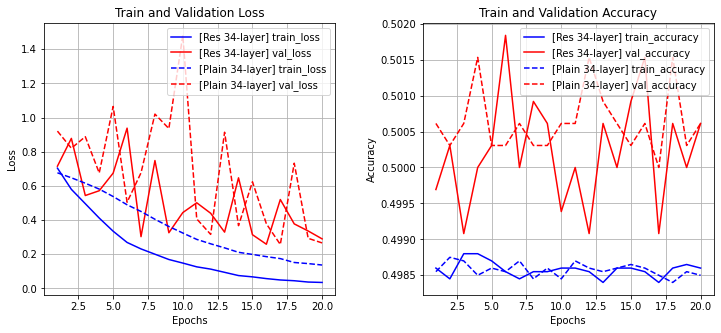

In [17]:
diff_history("Res 34-layer", resnet34_history,
             "Plain 34-layer", plainnet34_history)

### 50-layer network

In [18]:
resnet50 = build_resnet(input_shape=INPUT_SHAPE, num_classes=1, is_50=True)
plainnet50 = build_plainnet(input_shape=INPUT_SHAPE, num_classes=1, is_50=True)

resnet50_history = train(resnet50, epochs=EPOCHS)
plainnet50_history = train(plainnet50, epochs=EPOCHS)

Epoch 1/20
223/625 [=========>....................] - ETA: 2:14 - loss: 0.9116 - accuracy: 0.4978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 2:03 - loss: 0.8862 - accuracy: 0.4976

271/625 [============>.................] - ETA: 1:58 - loss: 0.8743 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 1:44 - loss: 0.8471 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:28 - loss: 0.8217 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.8190 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:22 - loss: 0.8149 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


536/625 [========================>.....] - ETA: 29s - loss: 0.7673 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.7485 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 235s 365ms/step - loss: 0.7485 - accuracy: 0.4985 - val_loss: 4.9626 - val_accuracy: 0.4991
Epoch 2/20
223/625 [=========>....................] - ETA: 2:14 - loss: 0.6215 - accuracy: 0.4971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


255/625 [===========>..................] - ETA: 2:03 - loss: 0.6223 - accuracy: 0.4973

268/625 [===========>..................] - ETA: 1:59 - loss: 0.6221 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


311/625 [=============>................] - ETA: 1:44 - loss: 0.6185 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:28 - loss: 0.6159 - accuracy: 0.5032

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.6164 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:22 - loss: 0.6157 - accuracy: 0.5020

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


536/625 [========================>.....] - ETA: 29s - loss: 0.6110 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6082 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 227s 362ms/step - loss: 0.6082 - accuracy: 0.4985 - val_loss: 0.9211 - val_accuracy: 0.5012
Epoch 3/20
220/625 [=========>....................] - ETA: 2:15 - loss: 0.5851 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.5814 - accuracy: 0.4974

271/625 [============>.................] - ETA: 1:57 - loss: 0.5818 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:44 - loss: 0.5758 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.5739 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:26 - loss: 0.5742 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:22 - loss: 0.5735 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 28s - loss: 0.5697 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 227s 362ms/step - loss: 0.5620 - accuracy: 0.4986 - val_loss: 0.8927 - val_accuracy: 0.5009
Epoch 4/20
220/625 [=========>....................] - ETA: 2:15 - loss: 0.5163 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.5130 - accuracy: 0.4976

271/625 [============>.................] - ETA: 1:58 - loss: 0.5127 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:44 - loss: 0.5060 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.5073 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.5077 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:23 - loss: 0.5057 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 29s - loss: 0.5013 - accuracy: 0.4977

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 227s 363ms/step - loss: 0.4940 - accuracy: 0.4984 - val_loss: 0.7815 - val_accuracy: 0.4997
Epoch 5/20
221/625 [=========>....................] - ETA: 2:14 - loss: 0.4626 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 2:03 - loss: 0.4583 - accuracy: 0.4974

270/625 [===========>..................] - ETA: 1:58 - loss: 0.4570 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 1:44 - loss: 0.4523 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 1:28 - loss: 0.4525 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:27 - loss: 0.4522 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:22 - loss: 0.4505 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 29s - loss: 0.4438 - accuracy: 0.4983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.4376 - accuracy: 0.4988 - val_loss: 1.1320 - val_accuracy: 0.5003
Epoch 6/20
222/625 [=========>....................] - ETA: 2:14 - loss: 0.4110 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.4074 - accuracy: 0.4973

271/625 [============>.................] - ETA: 1:58 - loss: 0.4062 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:44 - loss: 0.4030 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 1:28 - loss: 0.4037 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:27 - loss: 0.4030 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:23 - loss: 0.4021 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 29s - loss: 0.3992 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 227s 363ms/step - loss: 0.3934 - accuracy: 0.4985 - val_loss: 0.4854 - val_accuracy: 0.5000
Epoch 7/20
223/625 [=========>....................] - ETA: 2:14 - loss: 0.3737 - accuracy: 0.4971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.3699 - accuracy: 0.4972

269/625 [===========>..................] - ETA: 1:58 - loss: 0.3676 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:43 - loss: 0.3643 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.3695 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:25 - loss: 0.3694 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:22 - loss: 0.3691 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 28s - loss: 0.3690 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.3653 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.3653 - accuracy: 0.4987 - val_loss: 1.2369 - val_accuracy: 0.5003
Epoch 8/20
223/625 [=========>....................] - ETA: 2:14 - loss: 0.3383 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 2:01 - loss: 0.3368 - accuracy: 0.4976

269/625 [===========>..................] - ETA: 1:58 - loss: 0.3370 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 1:43 - loss: 0.3335 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:27 - loss: 0.3354 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:26 - loss: 0.3353 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:22 - loss: 0.3349 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 28s - loss: 0.3332 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.3289 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.3289 - accuracy: 0.4988 - val_loss: 0.7007 - val_accuracy: 0.5012
Epoch 9/20
223/625 [=========>....................] - ETA: 2:14 - loss: 0.3028 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 2:02 - loss: 0.3029 - accuracy: 0.4979

268/625 [===========>..................] - ETA: 1:59 - loss: 0.3030 - accuracy: 0.4973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:43 - loss: 0.2995 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.2984 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:26 - loss: 0.2988 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:23 - loss: 0.2983 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 29s - loss: 0.2927 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.4983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 227s 363ms/step - loss: 0.2891 - accuracy: 0.4983 - val_loss: 0.6628 - val_accuracy: 0.5012
Epoch 10/20
223/625 [=========>....................] - ETA: 2:14 - loss: 0.2758 - accuracy: 0.4966

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.2735 - accuracy: 0.4974

269/625 [===========>..................] - ETA: 1:58 - loss: 0.2743 - accuracy: 0.4973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:44 - loss: 0.2715 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.2681 - accuracy: 0.5030

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:27 - loss: 0.2678 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:22 - loss: 0.2662 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 28s - loss: 0.2655 - accuracy: 0.4984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.2617 - accuracy: 0.4986 - val_loss: 1.5278 - val_accuracy: 0.5000
Epoch 11/20
222/625 [=========>....................] - ETA: 2:14 - loss: 0.2418 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 2:02 - loss: 0.2390 - accuracy: 0.4977

270/625 [===========>..................] - ETA: 1:58 - loss: 0.2386 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 1:43 - loss: 0.2366 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:27 - loss: 0.2376 - accuracy: 0.5025

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:26 - loss: 0.2370 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:23 - loss: 0.2362 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 28s - loss: 0.2341 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.2325 - accuracy: 0.4986 - val_loss: 1.0961 - val_accuracy: 0.5006
Epoch 12/20
221/625 [=========>....................] - ETA: 2:14 - loss: 0.2274 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.2237 - accuracy: 0.4978

271/625 [============>.................] - ETA: 1:57 - loss: 0.2225 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:43 - loss: 0.2187 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.2191 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.2190 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:22 - loss: 0.2179 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 28s - loss: 0.2145 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.2093 - accuracy: 0.4986 - val_loss: 1.1785 - val_accuracy: 0.4994
Epoch 13/20
220/625 [=========>....................] - ETA: 2:15 - loss: 0.2058 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.2030 - accuracy: 0.4971

270/625 [===========>..................] - ETA: 1:58 - loss: 0.2006 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:44 - loss: 0.1989 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.1968 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:26 - loss: 0.1968 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:21 - loss: 0.1963 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 28s - loss: 0.1929 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.1917 - accuracy: 0.4987 - val_loss: 1.0474 - val_accuracy: 0.5006
Epoch 14/20
222/625 [=========>....................] - ETA: 2:14 - loss: 0.1818 - accuracy: 0.4977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


255/625 [===========>..................] - ETA: 2:03 - loss: 0.1809 - accuracy: 0.4975

271/625 [============>.................] - ETA: 1:57 - loss: 0.1805 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


311/625 [=============>................] - ETA: 1:44 - loss: 0.1788 - accuracy: 0.5002

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:28 - loss: 0.1794 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.1795 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:22 - loss: 0.1800 - accuracy: 0.5023

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


536/625 [========================>.....] - ETA: 29s - loss: 0.1765 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.1747 - accuracy: 0.4985 - val_loss: 0.4872 - val_accuracy: 0.5006
Epoch 15/20
222/625 [=========>....................] - ETA: 2:14 - loss: 0.1771 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 2:02 - loss: 0.1715 - accuracy: 0.4977

269/625 [===========>..................] - ETA: 1:58 - loss: 0.1707 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:43 - loss: 0.1700 - accuracy: 0.5011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:27 - loss: 0.1689 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.1686 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:21 - loss: 0.1674 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 28s - loss: 0.1595 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 227s 364ms/step - loss: 0.1557 - accuracy: 0.4986 - val_loss: 1.6133 - val_accuracy: 0.4994
Epoch 16/20
220/625 [=========>....................] - ETA: 2:15 - loss: 0.1641 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 2:02 - loss: 0.1599 - accuracy: 0.4973

268/625 [===========>..................] - ETA: 1:59 - loss: 0.1579 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:43 - loss: 0.1593 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:27 - loss: 0.1566 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.1559 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:22 - loss: 0.1543 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 28s - loss: 0.1513 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 227s 362ms/step - loss: 0.1503 - accuracy: 0.4985 - val_loss: 0.5217 - val_accuracy: 0.5015
Epoch 17/20
221/625 [=========>....................] - ETA: 2:14 - loss: 0.1438 - accuracy: 0.4975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


255/625 [===========>..................] - ETA: 2:03 - loss: 0.1411 - accuracy: 0.4971

270/625 [===========>..................] - ETA: 1:58 - loss: 0.1387 - accuracy: 0.4973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


311/625 [=============>................] - ETA: 1:44 - loss: 0.1381 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:28 - loss: 0.1396 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:26 - loss: 0.1396 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:21 - loss: 0.1382 - accuracy: 0.5021

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


395/625 [=================>............] - ETA: 1:16 - loss: 0.1364 - accuracy: 0.5020

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.1339 - accuracy: 0.4987 - val_loss: 1.1147 - val_accuracy: 0.4997
Epoch 18/20
220/625 [=========>....................] - ETA: 2:15 - loss: 0.1340 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 2:02 - loss: 0.1299 - accuracy: 0.4976

269/625 [===========>..................] - ETA: 1:58 - loss: 0.1293 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:43 - loss: 0.1283 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:27 - loss: 0.1246 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:26 - loss: 0.1242 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:22 - loss: 0.1234 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 28s - loss: 0.1228 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.1200 - accuracy: 0.4985 - val_loss: 1.1401 - val_accuracy: 0.5003
Epoch 19/20
223/625 [=========>....................] - ETA: 2:14 - loss: 0.1228 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 2:02 - loss: 0.1209 - accuracy: 0.4976

269/625 [===========>..................] - ETA: 1:58 - loss: 0.1205 - accuracy: 0.4976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 1:44 - loss: 0.1190 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:28 - loss: 0.1172 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:26 - loss: 0.1169 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:22 - loss: 0.1163 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


536/625 [========================>.....] - ETA: 29s - loss: 0.1135 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.1134 - accuracy: 0.4987 - val_loss: 0.5817 - val_accuracy: 0.4991
Epoch 20/20
220/625 [=========>....................] - ETA: 2:14 - loss: 0.1169 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 2:02 - loss: 0.1112 - accuracy: 0.4976

270/625 [===========>..................] - ETA: 1:58 - loss: 0.1092 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:43 - loss: 0.1075 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:27 - loss: 0.1056 - accuracy: 0.5032

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:26 - loss: 0.1051 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:21 - loss: 0.1045 - accuracy: 0.5021

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 28s - loss: 0.1055 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 226s 362ms/step - loss: 0.1058 - accuracy: 0.4986 - val_loss: 0.8003 - val_accuracy: 0.5006
Epoch 1/20
223/625 [=========>....................] - ETA: 1:55 - loss: 0.7217 - accuracy: 0.4971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:45 - loss: 0.7200 - accuracy: 0.4976

268/625 [===========>..................] - ETA: 1:42 - loss: 0.7191 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:29 - loss: 0.7165 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 1:15 - loss: 0.7142 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:14 - loss: 0.7141 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:10 - loss: 0.7132 - accuracy: 0.5021

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 25s - loss: 0.7092 - accuracy: 0.4984

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.7069 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 200s 314ms/step - loss: 0.7069 - accuracy: 0.4986 - val_loss: 0.7472 - val_accuracy: 0.4994
Epoch 2/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6959 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:44 - loss: 0.6943 - accuracy: 0.4973

270/625 [===========>..................] - ETA: 1:41 - loss: 0.6948 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:28 - loss: 0.6940 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:14 - loss: 0.6941 - accuracy: 0.5026

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6940 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:10 - loss: 0.6939 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 24s - loss: 0.6930 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6929 - accuracy: 0.4985 - val_loss: 0.6894 - val_accuracy: 0.5003
Epoch 3/20
222/625 [=========>....................] - ETA: 1:54 - loss: 0.6892 - accuracy: 0.4979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:44 - loss: 0.6904 - accuracy: 0.4976

271/625 [============>.................] - ETA: 1:40 - loss: 0.6908 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:28 - loss: 0.6912 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:14 - loss: 0.6918 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:13 - loss: 0.6917 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:10 - loss: 0.6919 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 24s - loss: 0.6918 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6922 - accuracy: 0.4986 - val_loss: 0.7033 - val_accuracy: 0.4997
Epoch 4/20
221/625 [=========>....................] - ETA: 1:55 - loss: 0.6903 - accuracy: 0.4980

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 1:44 - loss: 0.6909 - accuracy: 0.4976

269/625 [===========>..................] - ETA: 1:41 - loss: 0.6910 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 1:28 - loss: 0.6911 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:14 - loss: 0.6908 - accuracy: 0.5025

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6907 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:10 - loss: 0.6910 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 24s - loss: 0.6919 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6921 - accuracy: 0.4988 - val_loss: 0.6933 - val_accuracy: 0.4997
Epoch 5/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6807 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:44 - loss: 0.6784 - accuracy: 0.4972

271/625 [============>.................] - ETA: 1:40 - loss: 0.6774 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:28 - loss: 0.6780 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:14 - loss: 0.6762 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:14 - loss: 0.6763 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:10 - loss: 0.6761 - accuracy: 0.5024

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 24s - loss: 0.6767 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6744 - accuracy: 0.4986 - val_loss: 0.6995 - val_accuracy: 0.5015
Epoch 6/20
223/625 [=========>....................] - ETA: 1:54 - loss: 0.6656 - accuracy: 0.4971

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 1:45 - loss: 0.6642 - accuracy: 0.4976

270/625 [===========>..................] - ETA: 1:41 - loss: 0.6646 - accuracy: 0.4976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 1:29 - loss: 0.6650 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 1:15 - loss: 0.6625 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6627 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:10 - loss: 0.6626 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 25s - loss: 0.6586 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6575 - accuracy: 0.4987 - val_loss: 0.7046 - val_accuracy: 0.5006
Epoch 7/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6596 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:44 - loss: 0.6588 - accuracy: 0.4976

268/625 [===========>..................] - ETA: 1:41 - loss: 0.6591 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:28 - loss: 0.6570 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 1:15 - loss: 0.6583 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:13 - loss: 0.6586 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


379/625 [=================>............] - ETA: 1:10 - loss: 0.6589 - accuracy: 0.5021

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 25s - loss: 0.6585 - accuracy: 0.4983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 311ms/step - loss: 0.6602 - accuracy: 0.4984 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 8/20
223/625 [=========>....................] - ETA: 1:54 - loss: 0.6897 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:44 - loss: 0.6895 - accuracy: 0.4978

268/625 [===========>..................] - ETA: 1:41 - loss: 0.6891 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:28 - loss: 0.6875 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:14 - loss: 0.6865 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:13 - loss: 0.6866 - accuracy: 0.5033

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:10 - loss: 0.6862 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 24s - loss: 0.6789 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 194s 311ms/step - loss: 0.6751 - accuracy: 0.4986 - val_loss: 0.6628 - val_accuracy: 0.4991
Epoch 9/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6715 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:44 - loss: 0.6748 - accuracy: 0.4976

269/625 [===========>..................] - ETA: 1:41 - loss: 0.6750 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:28 - loss: 0.6772 - accuracy: 0.5004

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:14 - loss: 0.6762 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:14 - loss: 0.6763 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:10 - loss: 0.6762 - accuracy: 0.5027

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 24s - loss: 0.6765 - accuracy: 0.4983

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6747 - accuracy: 0.4987 - val_loss: 0.7488 - val_accuracy: 0.5006
Epoch 10/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6664 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:44 - loss: 0.6648 - accuracy: 0.4976

270/625 [===========>..................] - ETA: 1:41 - loss: 0.6641 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:28 - loss: 0.6650 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


361/625 [================>.............] - ETA: 1:15 - loss: 0.6643 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6643 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:10 - loss: 0.6640 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


537/625 [========================>.....] - ETA: 25s - loss: 0.6615 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6610 - accuracy: 0.4984 - val_loss: 0.8066 - val_accuracy: 0.5009
Epoch 11/20
221/625 [=========>....................] - ETA: 1:55 - loss: 0.6775 - accuracy: 0.4980

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


254/625 [===========>..................] - ETA: 1:45 - loss: 0.6798 - accuracy: 0.4977

271/625 [============>.................] - ETA: 1:40 - loss: 0.6808 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:28 - loss: 0.6821 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:14 - loss: 0.6852 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6852 - accuracy: 0.5027

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:10 - loss: 0.6852 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 24s - loss: 0.6835 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6809 - accuracy: 0.4988 - val_loss: 0.7353 - val_accuracy: 0.5003
Epoch 12/20
221/625 [=========>....................] - ETA: 1:55 - loss: 0.6683 - accuracy: 0.4969

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:44 - loss: 0.6678 - accuracy: 0.4979

268/625 [===========>..................] - ETA: 1:41 - loss: 0.6682 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:28 - loss: 0.6688 - accuracy: 0.5008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:14 - loss: 0.6713 - accuracy: 0.5025

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6715 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:10 - loss: 0.6718 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 24s - loss: 0.6762 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6767 - accuracy: 0.4984 - val_loss: 0.6861 - val_accuracy: 0.5003
Epoch 13/20
222/625 [=========>....................] - ETA: 1:54 - loss: 0.6917 - accuracy: 0.4972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 1:45 - loss: 0.6919 - accuracy: 0.4976

268/625 [===========>..................] - ETA: 1:41 - loss: 0.6920 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 1:29 - loss: 0.6923 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6931 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:10 - loss: 0.6930 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


536/625 [========================>.....] - ETA: 25s - loss: 0.6912 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 311ms/step - loss: 0.6891 - accuracy: 0.4986 - val_loss: 0.7678 - val_accuracy: 0.5003
Epoch 14/20
221/625 [=========>....................] - ETA: 1:55 - loss: 0.6937 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:44 - loss: 0.6937 - accuracy: 0.4969

270/625 [===========>..................] - ETA: 1:41 - loss: 0.6934 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:28 - loss: 0.6931 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:14 - loss: 0.6932 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


364/625 [================>.............] - ETA: 1:14 - loss: 0.6932 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:10 - loss: 0.6933 - accuracy: 0.5030

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 24s - loss: 0.6923 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 311ms/step - loss: 0.6909 - accuracy: 0.4988 - val_loss: 0.7835 - val_accuracy: 0.5012
Epoch 15/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6854 - accuracy: 0.4977

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


257/625 [===========>..................] - ETA: 1:44 - loss: 0.6853 - accuracy: 0.4976

269/625 [===========>..................] - ETA: 1:41 - loss: 0.6849 - accuracy: 0.4970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


313/625 [==============>...............] - ETA: 1:28 - loss: 0.6845 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:14 - loss: 0.6843 - accuracy: 0.5025

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6845 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:10 - loss: 0.6843 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 24s - loss: 0.6845 - accuracy: 0.4980

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 194s 311ms/step - loss: 0.6838 - accuracy: 0.4984 - val_loss: 0.6864 - val_accuracy: 0.5006
Epoch 16/20
221/625 [=========>....................] - ETA: 1:55 - loss: 0.6833 - accuracy: 0.4975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


259/625 [===========>..................] - ETA: 1:44 - loss: 0.6826 - accuracy: 0.4977

269/625 [===========>..................] - ETA: 1:41 - loss: 0.6823 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


315/625 [==============>...............] - ETA: 1:28 - loss: 0.6824 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:14 - loss: 0.6834 - accuracy: 0.5026

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


367/625 [================>.............] - ETA: 1:13 - loss: 0.6834 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


376/625 [=================>............] - ETA: 1:10 - loss: 0.6834 - accuracy: 0.5029

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 24s - loss: 0.6831 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 194s 311ms/step - loss: 0.6827 - accuracy: 0.4984 - val_loss: 0.6887 - val_accuracy: 0.5006
Epoch 17/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6824 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 1:45 - loss: 0.6823 - accuracy: 0.4974

270/625 [===========>..................] - ETA: 1:41 - loss: 0.6823 - accuracy: 0.4971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 1:29 - loss: 0.6820 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:15 - loss: 0.6809 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:14 - loss: 0.6809 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:10 - loss: 0.6806 - accuracy: 0.5026

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


536/625 [========================>.....] - ETA: 25s - loss: 0.6819 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 311ms/step - loss: 0.6833 - accuracy: 0.4985 - val_loss: 0.7839 - val_accuracy: 0.5006
Epoch 18/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6927 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:44 - loss: 0.6918 - accuracy: 0.4976

268/625 [===========>..................] - ETA: 1:41 - loss: 0.6914 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:28 - loss: 0.6907 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


362/625 [================>.............] - ETA: 1:14 - loss: 0.6898 - accuracy: 0.5028

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


365/625 [================>.............] - ETA: 1:13 - loss: 0.6896 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:10 - loss: 0.6893 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


538/625 [========================>.....] - ETA: 24s - loss: 0.6885 - accuracy: 0.4982

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.4985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6872 - accuracy: 0.4985 - val_loss: 0.6967 - val_accuracy: 0.5006
Epoch 19/20
220/625 [=========>....................] - ETA: 1:55 - loss: 0.6817 - accuracy: 0.4976

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


258/625 [===========>..................] - ETA: 1:44 - loss: 0.6797 - accuracy: 0.4973

271/625 [============>.................] - ETA: 1:40 - loss: 0.6791 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


314/625 [==============>...............] - ETA: 1:28 - loss: 0.6789 - accuracy: 0.5009

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


363/625 [================>.............] - ETA: 1:14 - loss: 0.6774 - accuracy: 0.5029

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:13 - loss: 0.6774 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


377/625 [=================>............] - ETA: 1:10 - loss: 0.6775 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


539/625 [========================>.....] - ETA: 24s - loss: 0.6797 - accuracy: 0.4979

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.4986

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6798 - accuracy: 0.4986 - val_loss: 0.6820 - val_accuracy: 0.5006
Epoch 20/20
221/625 [=========>....................] - ETA: 1:55 - loss: 0.6824 - accuracy: 0.4973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


256/625 [===========>..................] - ETA: 1:45 - loss: 0.6821 - accuracy: 0.4976

271/625 [============>.................] - ETA: 1:40 - loss: 0.6819 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


312/625 [=============>................] - ETA: 1:29 - loss: 0.6816 - accuracy: 0.5007

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


360/625 [================>.............] - ETA: 1:15 - loss: 0.6809 - accuracy: 0.5031

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


366/625 [================>.............] - ETA: 1:13 - loss: 0.6809 - accuracy: 0.5032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


378/625 [=================>............] - ETA: 1:10 - loss: 0.6805 - accuracy: 0.5028

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


536/625 [========================>.....] - ETA: 25s - loss: 0.6808 - accuracy: 0.4981

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


625/625 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.4988

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


625/625 [==============================] - 195s 312ms/step - loss: 0.6824 - accuracy: 0.4988 - val_loss: 0.6930 - val_accuracy: 0.5006


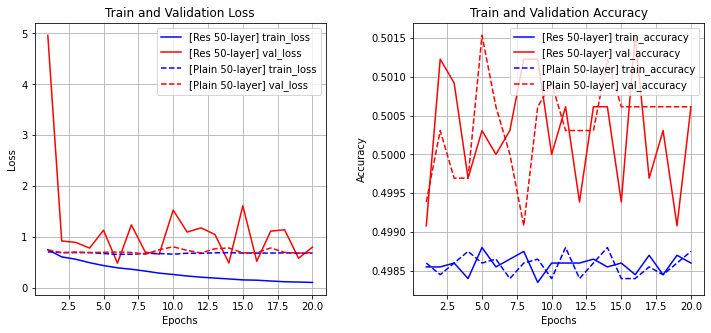

In [19]:
diff_history("Res 50-layer", resnet50_history,
             "Plain 50-layer", plainnet50_history)

## 회고

In [ ]:
- 코딩도 오래걸리고 훈련 자체에 시간이 오래걸려서